In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# train_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/Hikari_train_2labels.pkl')
# test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/Hikari_test_2labels.pkl')
train_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/RTIOT_train_2labels.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/RTIOT_test_2labels.pkl')


In [ ]:
train_df = train_df.drop(['proto'], axis=1)
train_df = train_df.drop(['service'], axis=1)
train_df = train_df.drop(['id.orig_p'], axis =1)
train_df = train_df.drop(['id.resp_p'], axis =1)
test_df = test_df.drop(['proto'], axis=1)
test_df = test_df.drop(['service'], axis=1)
test_df = test_df.drop(['id.orig_p'], axis =1)
test_df = test_df.drop(['id.resp_p'], axis =1)

In [ ]:
train_df = train_df.reset_index(drop=True)
train_df

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack,is_Normal
0,20.020917,10,6,3,4,4.994780e-01,2.996870e-01,7.991640e-01,0.6,328,...,17725537.06,17725537.06,17725537.06,17725537.06,0.0,64240,26847,502,False,True
1,0.000005,1,1,1,0,1.997288e+05,1.997288e+05,3.994575e+05,1.0,20,...,0.00,0.00,0.00,0.00,0.0,64,0,64,True,False
2,0.000003,1,1,1,0,3.495253e+05,3.495253e+05,6.990507e+05,1.0,20,...,0.00,0.00,0.00,0.00,0.0,64,0,64,True,False
3,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.0,20,...,0.00,0.00,0.00,0.00,0.0,64,0,64,True,False
4,0.001379,1,1,1,1,7.251563e+02,7.251563e+02,1.450313e+03,1.0,8,...,0.00,0.00,0.00,0.00,0.0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98488,0.000002,1,1,1,0,5.242880e+05,5.242880e+05,1.048576e+06,1.0,20,...,0.00,0.00,0.00,0.00,0.0,64,0,64,True,False
98489,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.0,20,...,0.00,0.00,0.00,0.00,0.0,64,0,64,True,False
98490,0.000002,1,1,1,0,4.660338e+05,4.660338e+05,9.320676e+05,1.0,20,...,0.00,0.00,0.00,0.00,0.0,64,0,64,True,False
98491,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.0,20,...,0.00,0.00,0.00,0.00,0.0,64,0,64,True,False


In [ ]:
test_df = test_df.reset_index(drop=True)
test_df

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack,is_Normal
0,0.027133,2,2,2,2,7.371101e+01,7.371101e+01,1.474220e+02,1.000000,16,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,False,True
1,100.475928,10,0,10,0,9.952600e-02,0.000000e+00,9.952600e-02,0.000000,80,...,9.040719e+06,35599052.91,93022574.90,23255643.73,1.184459e+07,0,0,0,True,False
2,0.000315,2,2,2,2,6.350195e+03,6.350195e+03,1.270039e+04,1.000000,16,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,True,False
3,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
4,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24619,0.000002,1,1,1,0,4.660338e+05,4.660338e+05,9.320676e+05,1.000000,20,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
24620,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
24621,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
24622,0.000005,1,1,1,0,1.997288e+05,1.997288e+05,3.994575e+05,1.000000,20,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False


In [ ]:
train_normal_data = train_df[train_df['is_Normal'] == True]
train_normal_data = train_normal_data.drop('is_Attack', axis=1)
train_normal_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
0,20.020917,10,6,3,4,0.499478,0.299687,0.799164,0.600000,328,...,0.0,17725537.06,17725537.06,17725537.06,17725537.06,0.0,64240,26847,502,True
6,45.072381,10,6,3,4,0.221865,0.133119,0.354985,0.600000,328,...,0.0,42789963.96,42789963.96,42789963.96,42789963.96,0.0,64240,26847,502,True
9,0.745822,7,5,2,1,9.385618,6.704013,16.089631,0.714286,232,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501,True
25,1.211034,14,10,3,8,11.560369,8.257406,19.817775,0.714286,444,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0,True
29,1.613707,15,12,3,9,9.295367,7.436294,16.731661,0.800000,464,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98436,62.108146,10,6,3,4,0.161009,0.096606,0.257615,0.600000,328,...,0.0,59805906.06,59805906.06,59805906.06,59805906.06,0.0,64240,26847,502,True
98450,0.027695,2,2,2,2,72.215356,72.215356,144.430713,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
98462,1.522084,14,12,3,9,9.197916,7.883928,17.081843,0.857143,432,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0,True
98473,0.939876,7,5,2,1,7.447790,5.319850,12.767641,0.714286,232,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501,True


In [ ]:
# train_normal_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/train_normal.pkl")
train_normal_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/train_normal.pkl")

In [ ]:
# X_train = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/train_normal.pkl")
X_train = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/train_normal.pkl")
X_train

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
0,20.020917,10,6,3,4,0.499478,0.299687,0.799164,0.600000,328,...,0.0,17725537.06,17725537.06,17725537.06,17725537.06,0.0,64240,26847,502,True
6,45.072381,10,6,3,4,0.221865,0.133119,0.354985,0.600000,328,...,0.0,42789963.96,42789963.96,42789963.96,42789963.96,0.0,64240,26847,502,True
9,0.745822,7,5,2,1,9.385618,6.704013,16.089631,0.714286,232,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501,True
25,1.211034,14,10,3,8,11.560369,8.257406,19.817775,0.714286,444,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0,True
29,1.613707,15,12,3,9,9.295367,7.436294,16.731661,0.800000,464,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98436,62.108146,10,6,3,4,0.161009,0.096606,0.257615,0.600000,328,...,0.0,59805906.06,59805906.06,59805906.06,59805906.06,0.0,64240,26847,502,True
98450,0.027695,2,2,2,2,72.215356,72.215356,144.430713,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
98462,1.522084,14,12,3,9,9.197916,7.883928,17.081843,0.857143,432,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0,True
98473,0.939876,7,5,2,1,7.447790,5.319850,12.767641,0.714286,232,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501,True


In [ ]:
X_train = X_train.drop('is_Normal', axis=1)
X_train

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,20.020917,10,6,3,4,0.499478,0.299687,0.799164,0.600000,328,...,2.295380e+06,0.0,17725537.06,17725537.06,17725537.06,17725537.06,0.0,64240,26847,502
6,45.072381,10,6,3,4,0.221865,0.133119,0.354985,0.600000,328,...,2.282417e+06,0.0,42789963.96,42789963.96,42789963.96,42789963.96,0.0,64240,26847,502
9,0.745822,7,5,2,1,9.385618,6.704013,16.089631,0.714286,232,...,7.476079e+05,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501
25,1.211034,14,10,3,8,11.560369,8.257406,19.817775,0.714286,444,...,1.211034e+06,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0
29,1.613707,15,12,3,9,9.295367,7.436294,16.731661,0.800000,464,...,1.616026e+06,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98436,62.108146,10,6,3,4,0.161009,0.096606,0.257615,0.600000,328,...,2.302240e+06,0.0,59805906.06,59805906.06,59805906.06,59805906.06,0.0,64240,26847,502
98450,0.027695,2,2,2,2,72.215356,72.215356,144.430713,1.000000,16,...,2.769494e+04,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0
98462,1.522084,14,12,3,9,9.197916,7.883928,17.081843,0.857143,432,...,1.524231e+06,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,0
98473,0.939876,7,5,2,1,7.447790,5.319850,12.767641,0.714286,232,...,9.417629e+05,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501


In [ ]:
test_normal_data = test_df[test_df['is_Normal'] == True]
test_normal_data = test_normal_data.drop('is_Attack', axis=1)
test_normal_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
0,0.027133,2,2,2,2,73.711012,73.711012,147.422024,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
16,0.027564,2,2,2,2,72.558281,72.558281,145.116562,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
27,19.053879,10,6,3,4,0.524828,0.314897,0.839724,0.600000,328,...,0.0,16757858.99,16757858.99,16757858.99,16757858.99,0.0,64240,26847,502,True
64,0.028153,2,2,2,2,71.039930,71.039930,142.079859,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
81,0.685586,7,5,2,1,10.210244,7.293031,17.503275,0.714286,232,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24576,0.029444,2,2,2,2,67.925601,67.925601,135.851203,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
24582,0.032593,2,2,2,2,61.362847,61.362847,122.725694,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
24589,0.038902,2,2,2,2,51.411180,51.411180,102.822360,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
24591,0.872557,7,5,2,1,8.022399,5.730285,13.752684,0.714286,232,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501,True


In [ ]:
# test_normal_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_normal.pkl")
test_normal_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/test_normal.pkl")

In [ ]:
# X_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_normal.pkl")
X_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/test_normal.pkl")
X_test

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
0,0.027133,2,2,2,2,73.711012,73.711012,147.422024,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
16,0.027564,2,2,2,2,72.558281,72.558281,145.116562,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
27,19.053879,10,6,3,4,0.524828,0.314897,0.839724,0.600000,328,...,0.0,16757858.99,16757858.99,16757858.99,16757858.99,0.0,64240,26847,502,True
64,0.028153,2,2,2,2,71.039930,71.039930,142.079859,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
81,0.685586,7,5,2,1,10.210244,7.293031,17.503275,0.714286,232,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24576,0.029444,2,2,2,2,67.925601,67.925601,135.851203,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
24582,0.032593,2,2,2,2,61.362847,61.362847,122.725694,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
24589,0.038902,2,2,2,2,51.411180,51.411180,102.822360,1.000000,16,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,True
24591,0.872557,7,5,2,1,8.022399,5.730285,13.752684,0.714286,232,...,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501,True


In [ ]:
X_test = X_test.drop('is_Normal', axis=1)
X_test

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,0.027133,2,2,2,2,73.711012,73.711012,147.422024,1.000000,16,...,2.713299e+04,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0
16,0.027564,2,2,2,2,72.558281,72.558281,145.116562,1.000000,16,...,2.756405e+04,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0
27,19.053879,10,6,3,4,0.524828,0.314897,0.839724,0.600000,328,...,2.296020e+06,0.0,16757858.99,16757858.99,16757858.99,16757858.99,0.0,64240,26847,502
64,0.028153,2,2,2,2,71.039930,71.039930,142.079859,1.000000,16,...,2.815318e+04,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0
81,0.685586,7,5,2,1,10.210244,7.293031,17.503275,0.714286,232,...,6.874180e+05,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24576,0.029444,2,2,2,2,67.925601,67.925601,135.851203,1.000000,16,...,2.944398e+04,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0
24582,0.032593,2,2,2,2,61.362847,61.362847,122.725694,1.000000,16,...,3.259301e+04,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0
24589,0.038902,2,2,2,2,51.411180,51.411180,102.822360,1.000000,16,...,3.890204e+04,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0
24591,0.872557,7,5,2,1,8.022399,5.730285,13.752684,0.714286,232,...,8.744390e+05,0.0,0.00,0.00,0.00,0.00,0.0,64240,26847,501


In [ ]:
# X_test_attack = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_attack.pkl")
X_test_attack = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/test_attack.pkl")
X_test_attack

# X_test_attack = X_test_attack.drop(['proto'], axis=1)
# X_test_attack = X_test_attack.drop(['service'], axis=1)
# X_test_attack = X_test_attack.drop(['id.orig_p'], axis =1)
# X_test_attack = X_test_attack.drop(['id.resp_p'], axis =1)

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack
0,100.475928,10,0,10,0,9.952600e-02,0.000000e+00,9.952600e-02,0.000000,80,...,4.983880e+06,9.040719e+06,35599052.91,93022574.90,23255643.73,1.184459e+07,0,0,0,True
1,0.000315,2,2,2,2,6.350195e+03,6.350195e+03,1.270039e+04,1.000000,16,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,True
2,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
3,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
4,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.000002,1,1,1,0,4.660338e+05,4.660338e+05,9.320676e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22118,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22119,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22120,0.000005,1,1,1,0,1.997288e+05,1.997288e+05,3.994575e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True


In [ ]:
X_test_attack = X_test_attack.drop('is_Attack', axis=1)
X_test_attack

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,100.475928,10,0,10,0,9.952600e-02,0.000000e+00,9.952600e-02,0.000000,80,...,3.726677e+06,4.983880e+06,9.040719e+06,35599052.91,93022574.90,23255643.73,1.184459e+07,0,0,0
1,0.000315,2,2,2,2,6.350195e+03,6.350195e+03,1.270039e+04,1.000000,16,...,3.149509e+02,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0
2,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,4.053116e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
3,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,9.536740e-01,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
4,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,4.053116e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.000002,1,1,1,0,4.660338e+05,4.660338e+05,9.320676e+05,1.000000,20,...,2.145767e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
22118,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,4.053116e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
22119,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,9.536740e-01,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
22120,0.000005,1,1,1,0,1.997288e+05,1.997288e+05,3.994575e+05,1.000000,20,...,5.006790e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64


In [ ]:
# Encode labels and scale features
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_attack = scaler.transform(X_test_attack)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
X_train = X_train.unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
X_test = X_test.unsqueeze(1)
X_test_attack = torch.tensor(X_test_attack, dtype=torch.float).to(device)
X_train.shape

torch.Size([10005, 1, 79])

In [ ]:
X_test.shape

torch.Size([2502, 1, 79])

In [ ]:
# class Data(Dataset):
#   def __init__(self, x, scale_data = True):
#       self.x = torch.FloatTensor(x)
#       self.len = self.x.shape[0]

#   def __getitem__(self, index):
#     return self.x[index]

#   def __len__(self):
#     return self.len

In [ ]:
# X_train = Data(X_train)
# X_test = Data(X_test)
# X_test_attack = Data(X_test_attack)

In [ ]:
# train_loader = DataLoader(X_train, batch_size=512, shuffle=True)
# test_loader = DataLoader(X_test, batch_size=512, shuffle=True)
# test_loader1 = DataLoader(X_test_attack, batch_size=512, shuffle=True)

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 79, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(79, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
           nn.ConvTranspose1d(32, 79,
                              kernel_size=3,
                              stride=2,
                              padding=1,
                              output_padding=1),
          nn.ReLU(),
          nn.ConvTranspose1d(79, 1,
                             kernel_size=2,
                             stride=2,
                             padding=1,
                             output_padding=1),
          nn.Sigmoid()
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [ ]:
# Initialize the autoencoder
model = AE().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

AE(
  (encoder): Sequential(
    (0): Conv1d(1, 79, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(79, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(32, 79, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(79, 1, kernel_size=(2,), stride=(2,), padding=(1,), output_padding=(1,))
    (3): Sigmoid()
  )
)


AUTOENCODER RECONSTRUCTION LOSS

Epoch 100/1000, Reconstruction Loss: 0.010220503434538841
Epoch 200/1000, Reconstruction Loss: 0.0035131892655044794
Epoch 300/1000, Reconstruction Loss: 0.0020307120867073536
Epoch 400/1000, Reconstruction Loss: 0.0014835587935522199
Epoch 500/1000, Reconstruction Loss: 0.0010028225369751453
Epoch 600/1000, Reconstruction Loss: 0.0006681448430754244
Epoch 700/1000, Reconstruction Loss: 0.0004853852151427418
Epoch 800/1000, Reconstruction Loss: 0.00039837267831899226
Epoch 900/1000, Reconstruction Loss: 0.0003377154062036425
Epoch 1000/1000, Reconstruction Loss: 0.0002968120388686657


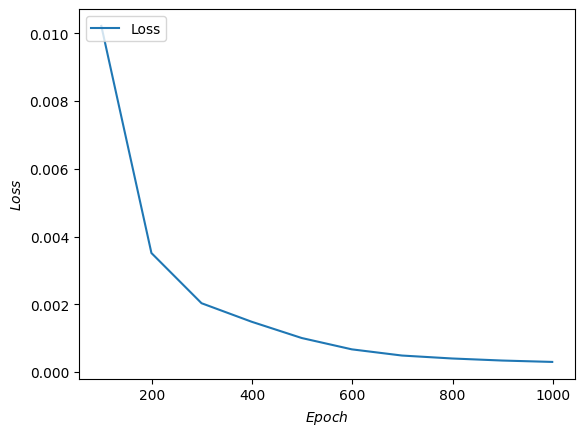

In [ ]:
# Training the Autoencoder
model.train()

x_axis = []
y_axis = []

outputs = []
epochs = 1000

print("AUTOENCODER RECONSTRUCTION LOSS\n")
for epoch in range(epochs):
  # for idx, data in enumerate(train_loader):
  #   x_train = data.to(device)
  optimizer.zero_grad()
  pred = model(X_train).to(device)
  loss = criterion(pred, X_train).to(device)

  loss.backward()
  optimizer.step()

  if (epoch+1) % 100 == 0:
    x_axis.append(epoch)
    y_axis.append(loss.item())
    print(f'Epoch {epoch+1}/{epochs}, Reconstruction Loss: {loss.item()}')

fig, x1 = plt.subplots()
x1.set_xlabel('$Epoch$')
x1.set_ylabel('$Loss$')
x1.plot(x_axis, y_axis, label="Loss")
x1.legend(loc='upper left')
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/RTIOT/model/AE_RIOT.pth")

In [ ]:
new_model = AE().to(device)

In [ ]:
new_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/RTIOT/model/AE_RIOT.pth"))

<All keys matched successfully>

In [ ]:
# Evaluate the Autoencoder on Test Data

model.eval()

with torch.no_grad():
  n = len(X_test)
  reconstructed = new_model(X_test).to(device)
  # normal_loss = torch.sum((X_test - reconstructed) ** 2, dim=1)
  normal_loss = (torch.sum((X_test - reconstructed) ** 2, dim=1)) / len(X_test)

normal_loss_np = normal_loss.cpu().numpy()  # Convert to numpy array
normal_loss_np = normal_loss_np.reshape(-1)
# print("AUTOENCODER RECONSTRUCTION LOSS\n")
# print(f'Test Loss: {loss.item():}')
print("Reconstruction normal error: ", normal_loss_np)
print("Reconstruction normal error percentile: ", np.percentile(normal_loss_np, [0, 25, 50, 75, 90, 95, 99]))
print("Size of normal loss: ", normal_loss_np.size)

Reconstruction normal error:  [1.1772124e-10 2.6571637e-08 7.2781342e-10 ... 1.5707963e-08 6.8736846e-08
 1.2891032e-07]
Reconstruction normal error percentile:  [2.61795822e-35 6.64667210e-09 1.58069637e-08 4.35149206e-08
 1.49056528e-07 3.38440600e-07 1.33458332e-06]
Size of normal loss:  197658


In [ ]:
print(format(np.percentile(normal_loss_np, [99])))

[1.33458332e-06]


In [ ]:
# Load the attack data
test_attack_data = pd.read_pickle('//content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/RTIOT_test_2labels.pkl')
test_attack_data

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack,is_Normal
10861,46774,53,udp,dns,0.027133,2,2,2,2,7.371101e+01,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,False,True
19045,68,67,udp,dhcp,100.475928,10,0,10,0,9.952600e-02,...,9.040719e+06,35599052.91,93022574.90,23255643.73,1.184459e+07,0,0,0,True,False
18986,54326,53,udp,dns,0.000315,2,2,2,2,6.350195e+03,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,True,False
89761,30032,21,tcp,-,0.000004,1,1,1,0,2.467238e+05,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
94259,62419,21,tcp,-,0.000001,1,1,1,0,1.048576e+06,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111841,3463,21,tcp,-,0.000002,1,1,1,0,4.660338e+05,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
49703,31823,21,tcp,-,0.000004,1,1,1,0,2.467238e+05,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
112267,3664,21,tcp,-,0.000001,1,1,1,0,1.048576e+06,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
45127,27179,21,tcp,-,0.000005,1,1,1,0,1.997288e+05,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False


In [ ]:
test_attack_data = test_df[test_df['is_Attack'] == True]
test_attack_data = test_attack_data.drop('is_Normal', axis=1)
test_attack_data = test_attack_data.reset_index(drop=True)
test_attack_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack
0,100.475928,10,0,10,0,9.952600e-02,0.000000e+00,9.952600e-02,0.000000,80,...,4.983880e+06,9.040719e+06,35599052.91,93022574.90,23255643.73,1.184459e+07,0,0,0,True
1,0.000315,2,2,2,2,6.350195e+03,6.350195e+03,1.270039e+04,1.000000,16,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,True
2,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
3,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
4,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.000002,1,1,1,0,4.660338e+05,4.660338e+05,9.320676e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22118,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22119,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22120,0.000005,1,1,1,0,1.997288e+05,1.997288e+05,3.994575e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True


In [ ]:
test_attack_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/test_attack.pkl")

In [ ]:
X_test_attack = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/test_attack.pkl")
X_test_attack

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack
0,100.475928,10,0,10,0,9.952600e-02,0.000000e+00,9.952600e-02,0.000000,80,...,4.983880e+06,9.040719e+06,35599052.91,93022574.90,23255643.73,1.184459e+07,0,0,0,True
1,0.000315,2,2,2,2,6.350195e+03,6.350195e+03,1.270039e+04,1.000000,16,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,True
2,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
3,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
4,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.000002,1,1,1,0,4.660338e+05,4.660338e+05,9.320676e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22118,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22119,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True
22120,0.000005,1,1,1,0,1.997288e+05,1.997288e+05,3.994575e+05,1.000000,20,...,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True


In [ ]:
X_test_attack = X_test_attack.drop('is_Attack', axis=1)
X_test_attack

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,100.475928,10,0,10,0,9.952600e-02,0.000000e+00,9.952600e-02,0.000000,80,...,3.726677e+06,4.983880e+06,9.040719e+06,35599052.91,93022574.90,23255643.73,1.184459e+07,0,0,0
1,0.000315,2,2,2,2,6.350195e+03,6.350195e+03,1.270039e+04,1.000000,16,...,3.149509e+02,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0
2,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,4.053116e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
3,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,9.536740e-01,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
4,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,4.053116e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22117,0.000002,1,1,1,0,4.660338e+05,4.660338e+05,9.320676e+05,1.000000,20,...,2.145767e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
22118,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,1.000000,20,...,4.053116e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
22119,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,1.000000,20,...,9.536740e-01,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64
22120,0.000005,1,1,1,0,1.997288e+05,1.997288e+05,3.994575e+05,1.000000,20,...,5.006790e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64


In [ ]:
# Scale the anomalous data
X_test_attack = scaler.transform(X_test_attack)

# Convert to PyTorch tensors
X_test_attack = torch.tensor(X_test_attack, dtype=torch.float).to(device)
X_test_attack = X_test_attack.unsqueeze(1)
X_test_attack.shape

torch.Size([22122, 1, 79])

In [ ]:
# Compute Reconstruction Errors for anomaly Data

with torch.no_grad():
  # n = len(X_test_attack)
  reconstructed_attack = new_model(X_test_attack).to(device)
  # attack_loss = torch.sum((X_test_attack - reconstructed_attack) ** 2, dim=1)
  attack_loss = (torch.sum(abs(X_test_attack - reconstructed_attack) ** 2, dim=1)) / len(X_test_attack)

attack_loss_np = attack_loss.cpu().numpy()  # Convert to numpy array
attack_loss_np = attack_loss_np.reshape(-1)
print("Reconstruction attack error: ", attack_loss_np)
print("Reconstruction attack error percentile: ", np.percentile(attack_loss.cpu(), [0, 25, 50, 75, 90, 95, 99]))
print("Size of attack loss: ", attack_loss_np.size)

Reconstruction attack error:  [7.43025586e-10 2.17155005e-09 1.12729485e-10 ... 4.11270706e-09
 9.95288616e-08 1.61692753e-07]
Reconstruction attack error percentile:  [0.00000000e+00 8.72067141e-10 2.06911488e-09 1.83598043e-08
 3.64403377e-07 4.51973210e-05 1.73063725e-01]
Size of attack loss:  1747638


In [ ]:
print(format(np.percentile(attack_loss_np, [99])))

[0.17306373]


Text(0.5, 0, 'Index')

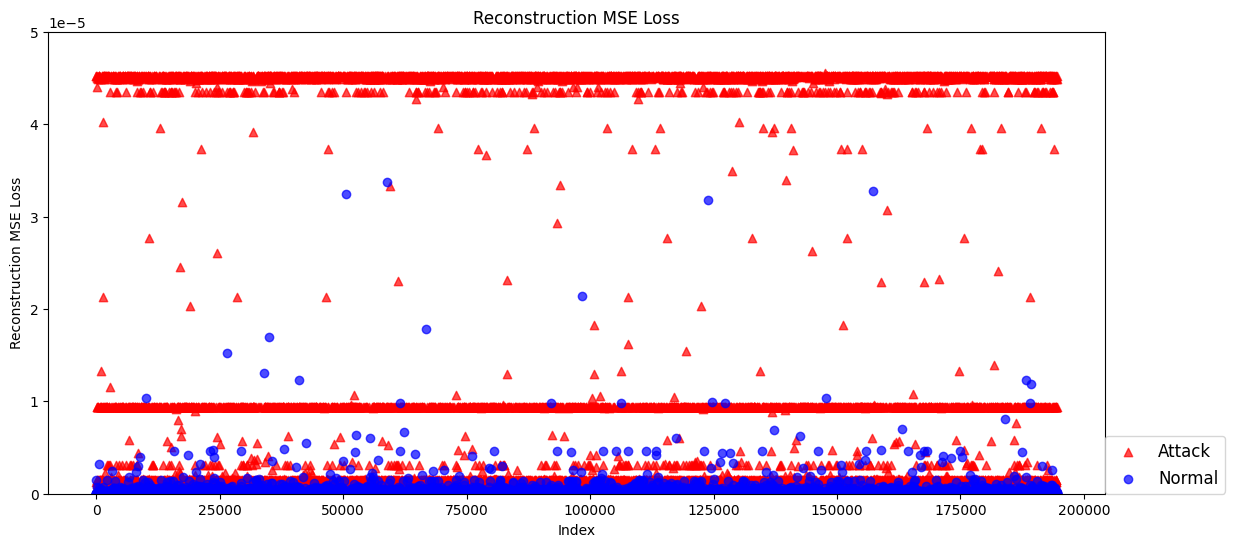

In [ ]:
loss_df = pd.DataFrame()
loss_df['Class'] = [0] * len(normal_loss_np) + [1] * len(attack_loss_np)
loss_df['MSELoss'] = np.hstack([normal_loss_np, attack_loss_np])
loss_df = loss_df.sample(frac=0.1).reset_index(drop=True)

markers = ['o', '^']
markers = ['o', '^']
colors = ['blue', 'red']
labels = ['Normal', 'Attack']

plt.figure(figsize=(30, 6))
plt.subplot(121)
for flag in [1, 0]:
    temp = loss_df[loss_df['Class'] == flag]
    plt.scatter(temp.index,
                temp['MSELoss'],
                alpha=0.7,
                marker=markers[flag],
                c=colors[flag],
                label=labels[flag])
plt.ylim(0, 0.00005)
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE Loss')
plt.ylabel('Reconstruction MSE Loss')
plt.xlabel('Index')

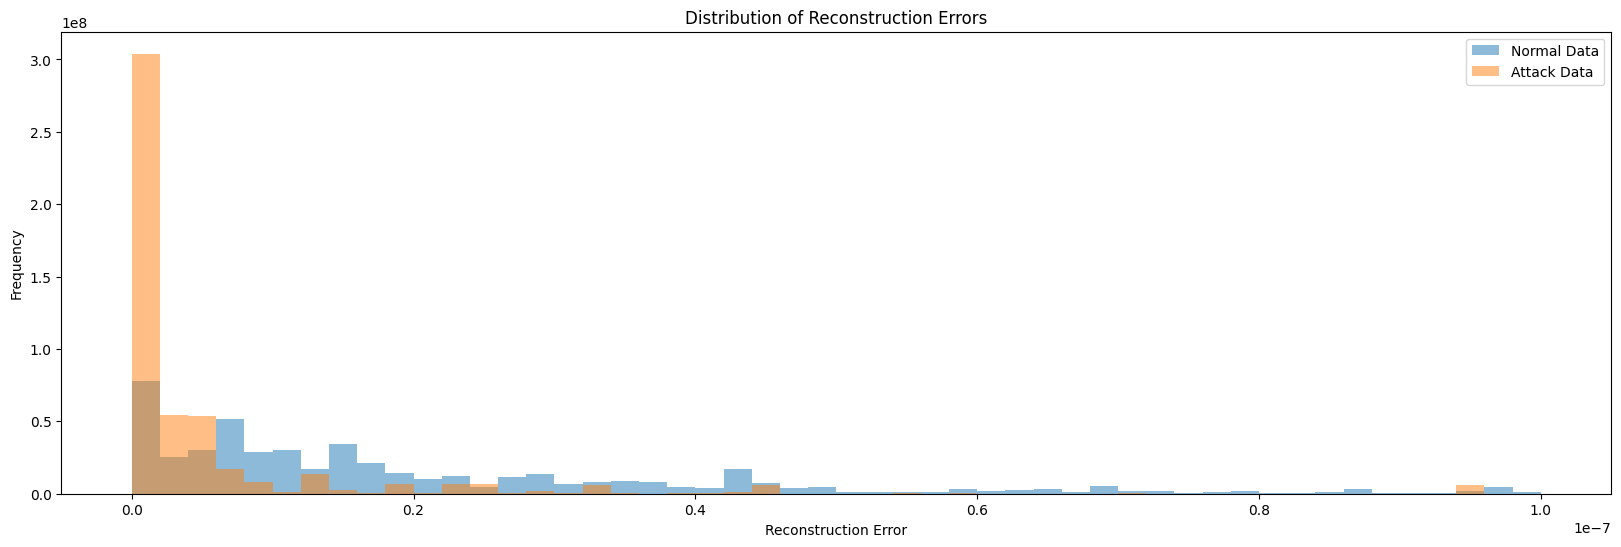

Threshold at 90th percentile: 1.4905652818697502e-07
Threshold at 95th percentile: 3.3844059998955345e-07
Threshold at 99th percentile: 1.3345833167477394e-06
Mean Reconstruction Error for Normal Data: 1.5352021875969513e-07
Standard Deviation for Normal Data: 1.6805068298708647e-05


In [ ]:
# Plotting histograms of reconstruction errors
plt.figure(figsize=(20, 6))
plt.hist(normal_loss_np, bins=50, alpha=0.5, range=[0, 0.0000001], histtype='stepfilled', density=True, label='Normal Data')
plt.hist(attack_loss_np, bins=50, alpha=0.5, range=[0, 0.0000001], histtype='stepfilled', density=True, label='Attack Data')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

# Using Percentiles to determine threshold
percentiles = [90, 95, 99]
for p in percentiles:
    threshold = np.percentile(normal_loss_np, p)
    print(f"Threshold at {p}th percentile: {threshold:}")

# Additional statistical analysis (Optional)
mean_normal = np.mean(normal_loss_np)
std_normal = np.std(normal_loss_np)
print(f"Mean Reconstruction Error for Normal Data: {mean_normal:}")
print(f"Standard Deviation for Normal Data: {std_normal:}")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the threshold as the 95th percentile of normal reconstruction errors
threshold = np.percentile(normal_loss_np, 92) #Threshold for classification
print("threshold:", threshold)

# Classify as attack if reconstruction error exceeds the threshold
y_pred_test = (torch.sum(abs(X_test - reconstructed) ** 2, dim=1) / len(X_test)) > threshold
y_pred_anomalous = (torch.sum(abs(X_test_attack - reconstructed_attack)**2, dim=1) / len(X_test_attack)) > threshold
# y_pred_test = (torch.sum(abs(X_test - reconstructed) ** 2, dim=1) / len(X_test)).mean(dim=1) > threshold
# y_pred_anomalous = (torch.sum(abs(X_test_attack - reconstructed_attack)**2, dim=1) / len(X_test_attack)).mean(dim=1) > threshold

# squared_diff_test = abs(X_test - reconstructed) ** 2
# sum_squared_diff_test = torch.sum(squared_diff_test, dim=1)
# normalized_error_test = sum_squared_diff_test / len(X_test)
# mean_error_test = normalized_error_test.mean(dim=1)
# y_pred_test = mean_error_test > threshold


# squared_diff_anomalous = abs(X_test_attack - reconstructed_attack) ** 2
# sum_squared_diff_anomalous = torch.sum(squared_diff_anomalous, dim=1)
# normalized_error_anomalous = sum_squared_diff_anomalous / len(X_test_attack)
# mean_error_anomalous = normalized_error_anomalous.mean(dim=1)
# y_pred_anomalous = mean_error_anomalous > threshold




y_pred_test = y_pred_test.cpu()
y_pred_anomalous = y_pred_anomalous.cpu()

# True labels: 0 for normal, 1 for attack
y_true_test = np.zeros(len(y_pred_test))
y_true_anomalous = np.ones(len(y_pred_anomalous))

# Combine predictions and true labels
y_pred_combined = np.concatenate([y_pred_test.numpy().astype(int), y_pred_anomalous.numpy().astype(int)])
y_true_combined = np.concatenate([y_true_test, y_true_anomalous])

# Calculate accuracy
accuracy = accuracy_score(y_true_combined, y_pred_combined)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_combined, y_pred_combined)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

threshold: 1.9682595109316026e-07
Accuracy: 0.8302
Confusion Matrix:
[[ 2405    97]
 [ 4083 18039]]


In [ ]:
from sklearn.metrics import classification_report

target_names = ['Normal', 'Attack']
print(classification_report(y_true_combined, y_pred_combined, target_names=target_names, digits=4))
print(confusion_matrix(y_true_combined, y_pred_combined))

              precision    recall  f1-score   support

      Normal     0.3707    0.9612    0.5350      2502
      Attack     0.9947    0.8154    0.8962     22122

    accuracy                         0.8302     24624
   macro avg     0.6827    0.8883    0.7156     24624
weighted avg     0.9313    0.8302    0.8595     24624

[[ 2405    97]
 [ 4083 18039]]
